In [1]:
import numpy as np
from numpy import unique
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from random import random
import time
import warnings
import statistics
from math import sqrt
from scipy import stats
from sklearn.metrics import mean_squared_error
from datetime import datetime
from scipy.stats import norm
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_predict
from pandas.plotting import autocorrelation_plot

# Utility Functions

In [2]:
def plot_indexed_dataset(indexed_dataset, xlabel="Time(hh:mm)", ylabel="Bpm (beats per minute)"):
    indexed_dataset.plot(figsize=(12,8))
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.tick_params(axis='x', labelsize=6)
    plt.tick_params(axis='y', labelsize=10)
    plt.grid(alpha=0.1)
    plt.legend()
    plt.show()

In [3]:
def original_predicted_comparison(original_test, predicted_test, xlabel="Time(hh:mm)", ylabel="Bpm (beats per minute)"):
    plt.figure(figsize = (12,8)) # declaire environment to draw
    plt.plot(original_test, c='blue', label='Test_set')
    plt.plot(predicted_test, c='red', label='Test_set prediction')
    plt.xlabel("Timestamp", fontsize=16)
    plt.ylabel("Bpm (beats per minute)", fontsize=16)
    plt.tick_params(axis='x', labelsize=6)
    plt.tick_params(axis='y', labelsize=10)
    plt.grid(alpha=0.1)
    plt.legend()
    plt.show()

In [4]:
def plot_full_series_vs_predicted_test(trainset, testset, predicted_test):
    plt.figure(figsize = (12,8)) # declaire environment to draw
    plt.plot(trainset, c='green', label='Test_set')
    plt.plot(testset, c='blue', label='Test_set')
    plt.plot(predicted_test, c='red', label='Test_set prediction')
    plt.xlabel("Timestamp", fontsize=16)
    plt.ylabel("Bpm (beats per minute)", fontsize=16)
    plt.tick_params(axis='x', labelsize=6)
    plt.tick_params(axis='y', labelsize=10)
    plt.grid(alpha=0.1)
    plt.legend()
    plt.show()

# Getting data

In [5]:
heartrate_df = pd.read_csv ('.\Data\HEARTRATE_AUTO_1658994387948.csv', sep=',', header=0)

In [6]:
heartrate_df

,date,time,heartRate
0,2022-06-12,09:25,68
1,2022-06-12,09:28,68
2,2022-06-12,09:35,80
3,2022-06-12,09:45,70
4,2022-06-12,09:55,64
...,...,...,...
2312,2022-06-19,23:16,80
2313,2022-06-19,23:26,61
2314,2022-06-19,23:36,70
2315,2022-06-19,23:46,70


In [7]:
heartrate_df['date'] = pd.to_datetime(heartrate_df['date'],infer_datetime_format=True) #convert from string to datetime
heartrate_df['time'] = pd.to_datetime(heartrate_df['time'], format='%H:%M').dt.strftime("%H:%M")

heartrate_df['date'] = pd.to_datetime(heartrate_df['date'].astype(str)+' '+heartrate_df['time'].astype(str), format='%Y-%m-%d %H:%M')
heartrate_df['date'] = heartrate_df['date'].dt.strftime('%Y-%m-%d %H:%M')
heartrate_df = heartrate_df.drop(columns=['time'])

# generating the indexed dataset
indexed_dataset = heartrate_df.set_index(['date'])

In [8]:
starting_date = datetime.strptime(heartrate_df['date'].iloc[0], '%Y-%m-%d %H:%M').strftime("%Y-%m-%d")
end_date = datetime.strptime(heartrate_df['date'].iloc[-1], '%Y-%m-%d %H:%M').strftime("%Y-%m-%d")
print('Start date: {}\nEnd date: {}'.format(starting_date, end_date))

Start date: 2022-06-12
End date: 2022-06-19


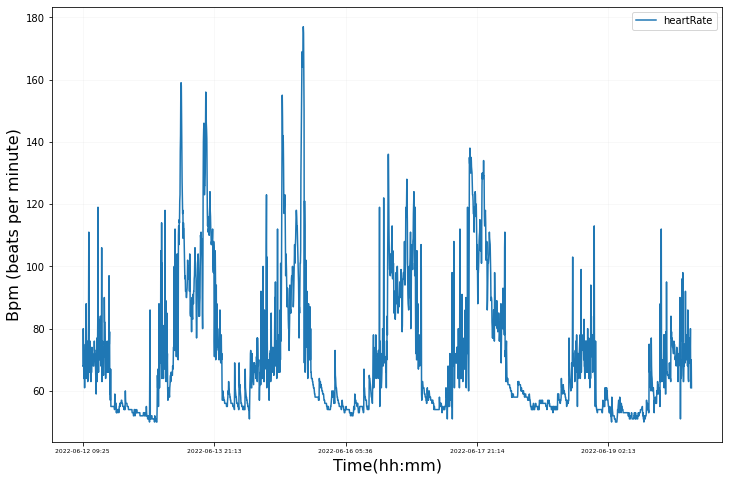

In [9]:
plot_indexed_dataset(indexed_dataset)

# Trying to predict the last day

Source 1: https://machinelearningmastery.com/make-sample-forecasts-arima-python/<br>
Source 2: https://machinelearningmastery.com/make-manual-predictions-arima-models-python/

In [10]:
X = heartrate_df[['date']]
Y = heartrate_df[['heartRate']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=1/7, shuffle=False)
train_dataset = pd.concat([X_train,y_train],axis=1)
test_dataset = pd.concat([X_test, y_test], axis=1)

indexed_train = train_dataset.set_index(['date'])
indexed_test = test_dataset.set_index(['date'])

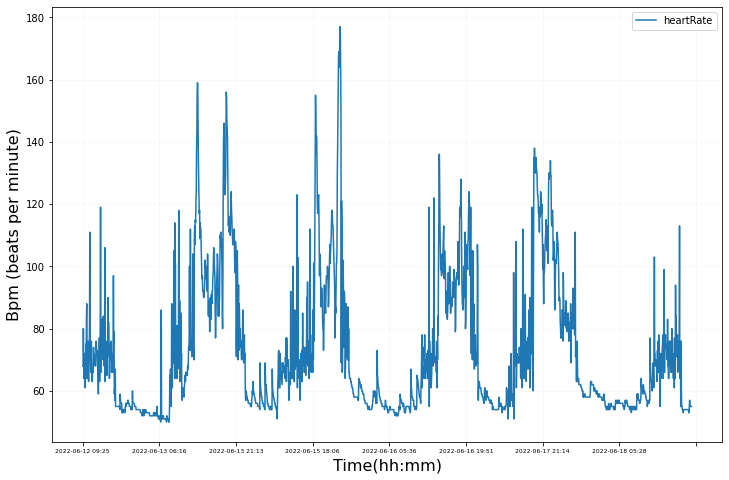

In [11]:
plot_indexed_dataset(indexed_train)

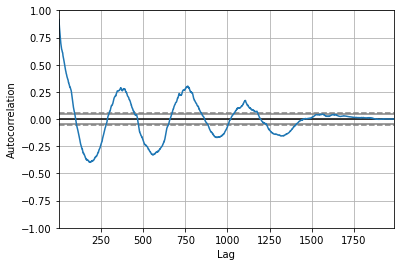

In [12]:
autocorrelation_plot(indexed_train)
plt.show()

In [13]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

In [14]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [15]:
def predict(coef, history):
    yhat = 0.0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat


# EVALUATING ARIMA parameters

Source : https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [16]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [17]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [19]:
# evaluate parameters
#p_values = [0, 1, 2, 4, 6, 8, 10]
#d_values = range(0, 3)
#q_values = range(0, 3)
#warnings.filterwarnings("ignore")
#evaluate_models(indexed_train['heartRate'], p_values, d_values, q_values)
'''
ARIMA(0, 0, 0) MSE=416.393
ARIMA(0, 0, 1) MSE=192.639
ARIMA(0, 0, 2) MSE=131.317
ARIMA(0, 1, 0) MSE=66.791
ARIMA(0, 1, 1) MSE=53.648
ARIMA(0, 1, 2) MSE=53.640
ARIMA(0, 2, 0) MSE=187.018
ARIMA(0, 2, 1) MSE=66.837
ARIMA(0, 2, 2) MSE=53.697
ARIMA(1, 0, 0) MSE=64.200
ARIMA(1, 0, 1) MSE=53.379
ARIMA(1, 0, 2) MSE=53.411
ARIMA(1, 1, 0) MSE=56.749
ARIMA(1, 1, 1) MSE=53.555
ARIMA(1, 1, 2) MSE=53.767
ARIMA(1, 2, 0) MSE=110.290
ARIMA(1, 2, 1) MSE=56.790
ARIMA(1, 2, 2) MSE=53.605
ARIMA(2, 0, 0) MSE=55.843
ARIMA(2, 0, 1) MSE=53.347
ARIMA(2, 0, 2) MSE=53.594
ARIMA(2, 1, 0) MSE=55.005
ARIMA(2, 1, 1) MSE=53.781
ARIMA(2, 1, 2) MSE=53.833
ARIMA(2, 2, 0) MSE=88.493
ARIMA(2, 2, 1) MSE=55.044
ARIMA(2, 2, 2) MSE=53.843
ARIMA(4, 0, 0) MSE=54.049
ARIMA(4, 0, 1) MSE=53.734
ARIMA(4, 0, 2) MSE=53.716
ARIMA(4, 1, 0) MSE=54.109
ARIMA(4, 1, 1) MSE=53.864
ARIMA(4, 1, 2) MSE=54.305
ARIMA(4, 2, 0) MSE=74.345
ARIMA(4, 2, 1) MSE=54.153
ARIMA(4, 2, 2) MSE=54.760
ARIMA(6, 0, 0) MSE=53.952
ARIMA(6, 0, 1) MSE=54.049
ARIMA(6, 0, 2) MSE=53.578
ARIMA(6, 1, 0) MSE=53.988
ARIMA(6, 1, 1) MSE=54.125
ARIMA(6, 1, 2) MSE=54.299
ARIMA(6, 2, 0) MSE=66.720
ARIMA(6, 2, 2) MSE=54.622
ARIMA(8, 0, 0) MSE=54.052
ARIMA(8, 0, 1) MSE=54.451
ARIMA(8, 0, 2) MSE=54.616
ARIMA(8, 1, 0) MSE=54.229
ARIMA(8, 1, 1) MSE=54.389
ARIMA(8, 1, 2) MSE=54.709
ARIMA(8, 2, 0) MSE=62.106
'''

'\nARIMA(0, 0, 0) MSE=416.393\nARIMA(0, 0, 1) MSE=192.639\nARIMA(0, 0, 2) MSE=131.317\nARIMA(0, 1, 0) MSE=66.791\nARIMA(0, 1, 1) MSE=53.648\nARIMA(0, 1, 2) MSE=53.640\nARIMA(0, 2, 0) MSE=187.018\nARIMA(0, 2, 1) MSE=66.837\nARIMA(0, 2, 2) MSE=53.697\nARIMA(1, 0, 0) MSE=64.200\nARIMA(1, 0, 1) MSE=53.379\nARIMA(1, 0, 2) MSE=53.411\nARIMA(1, 1, 0) MSE=56.749\nARIMA(1, 1, 1) MSE=53.555\nARIMA(1, 1, 2) MSE=53.767\nARIMA(1, 2, 0) MSE=110.290\nARIMA(1, 2, 1) MSE=56.790\nARIMA(1, 2, 2) MSE=53.605\nARIMA(2, 0, 0) MSE=55.843\nARIMA(2, 0, 1) MSE=53.347\nARIMA(2, 0, 2) MSE=53.594\nARIMA(2, 1, 0) MSE=55.005\nARIMA(2, 1, 1) MSE=53.781\nARIMA(2, 1, 2) MSE=53.833\nARIMA(2, 2, 0) MSE=88.493\nARIMA(2, 2, 1) MSE=55.044\nARIMA(2, 2, 2) MSE=53.843\nARIMA(4, 0, 0) MSE=54.049\nARIMA(4, 0, 1) MSE=53.734\nARIMA(4, 0, 2) MSE=53.716\nARIMA(4, 1, 0) MSE=54.109\nARIMA(4, 1, 1) MSE=53.864\nARIMA(4, 1, 2) MSE=54.305\nARIMA(4, 2, 0) MSE=74.345\nARIMA(4, 2, 1) MSE=54.153\nARIMA(4, 2, 2) MSE=54.760\nARIMA(6, 0, 0) MSE=5

In [20]:
# seasonal difference
measures_in_a_day = 331 # test set size
differenced = difference(indexed_train['heartRate'].tolist(), measures_in_a_day)
# fit model
model = ARIMA(differenced, order=(1,1,1))
model_fit = model.fit()
# print summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1655
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6487.216
Date:                Wed, 03 Aug 2022   AIC                          12980.433
Time:                        09:31:47   BIC                          12996.666
Sample:                             0   HQIC                         12986.451
                               - 1655                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2067      0.042      4.978      0.000       0.125       0.288
ma.L1         -0.5840      0.037    -15.854      0.000      -0.656      -0.512
sigma2       149.3415      2.713     55.042      0.0

## Residual

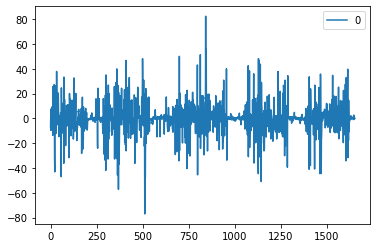

In [21]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

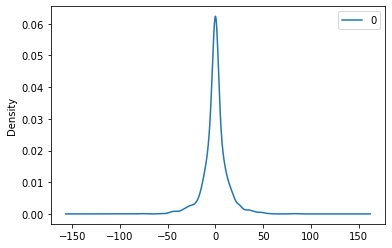

                 0
count  1655.000000
mean      0.000507
std      12.222123
min     -77.066500
25%      -4.453336
50%      -0.033693
75%       4.261559
max      82.341479


In [22]:
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

## Forecast function

The statsmodel ARIMAResults object provides a forecast() function for making predictions.

By default, this function makes a single step out-of-sample forecast. As such, we can call it directly and make our forecast. The result of the forecast() function is an array containing the forecast value, the standard error of the forecast, and the confidence interval information. Now, we are only interested in the first element of this forecast, as follows.

In [23]:
# one-step out-of sample forecast
forecast = model_fit.forecast()[0]
# invert the differenced forecast to something usable
forecast = inverse_difference(indexed_dataset['heartRate'], forecast, measures_in_a_day)
print('Forecast: %f' % forecast)

Forecast: 52.006709


## Predict Function

The statsmodel ARIMAResults object also provides a predict() function for making forecasts.

The predict function can be used to predict arbitrary in-sample and out-of-sample time steps, including the next out-of-sample forecast time step.

The predict function requires a start and an end to be specified, these can be the indexes of the time steps relative to the beginning of the training data used to fit the model, for example:

In [24]:
# one-step out of sample forecast
start_index = len(differenced)
end_index = len(differenced)
forecast = model_fit.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
forecast = inverse_difference(indexed_dataset['heartRate'], forecast, measures_in_a_day)
print('Forecast: %f' % forecast)

Forecast: 52.006709


You can see that the predict function is more flexible. You can specify any point or contiguous forecast interval in or out of sample.

Now that we know how to make a one-step forecast, we can now make some multi-step forecasts

# Multi-Step Out-of-Sample Forecast

We can also make multi-step forecasts using the forecast() and predict() functions.

In this section we will look at predicting the heartRate bpm for the next day out-of-sample steps.

## Forecast Function

The forecast() function has an argument called steps that allows you to specify the number of time steps to forecast

In [25]:
# multi-step out-of-sample forecast
forecast = model_fit.forecast(steps=331)

We can then invert each forecasted time step, one at a time and print the values. Note that to invert the forecast value for t+2, we need the inverted forecast value for t+1. Here, we add them to the end of a list called history for use when calling inverse_difference().

In [26]:
# invert the differenced forecast to something usable
history = [x for x in indexed_dataset['heartRate']]
measure = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, measures_in_a_day)
    history.append(inverted)
    measure += 1

## Predict Function off-line Algorithm

The predict() function can also forecast the next day (331 measures)

In [27]:
# multi-step out-of-sample forecast
start_index = len(differenced)
end_index = start_index + (measures_in_a_day-1)
forecast = model_fit.predict(start=start_index, end=end_index)

In [28]:
# invert the differenced forecast to something usable
history = [x for x in indexed_train['heartRate']]
forecasting = []
measure = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, measures_in_a_day)
    history.append(inverted)
    forecasting.append(inverted)
    measure += 1

In [29]:
predicted_df = pd.DataFrame(test_dataset['date'], columns=['date'])
predicted_df['heartRate'] = forecasting

indexed_predicted_test = predicted_df.set_index(['date'])

In [30]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test_dataset['heartRate'], forecasting))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 10.476


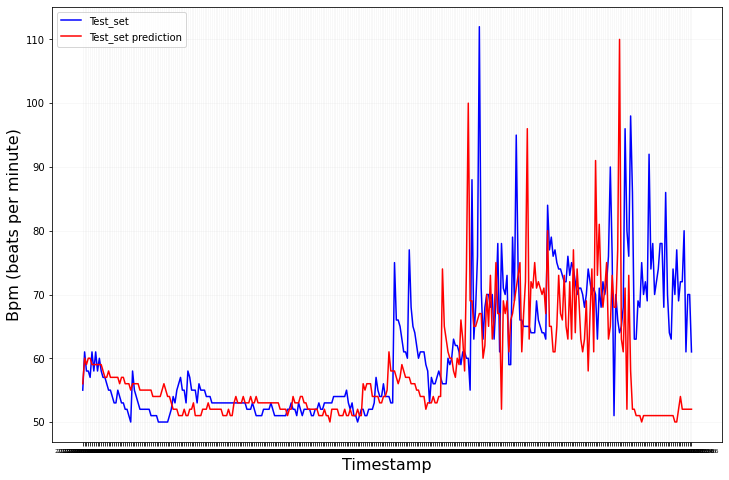

In [31]:
original_predicted_comparison(indexed_test, indexed_predicted_test)

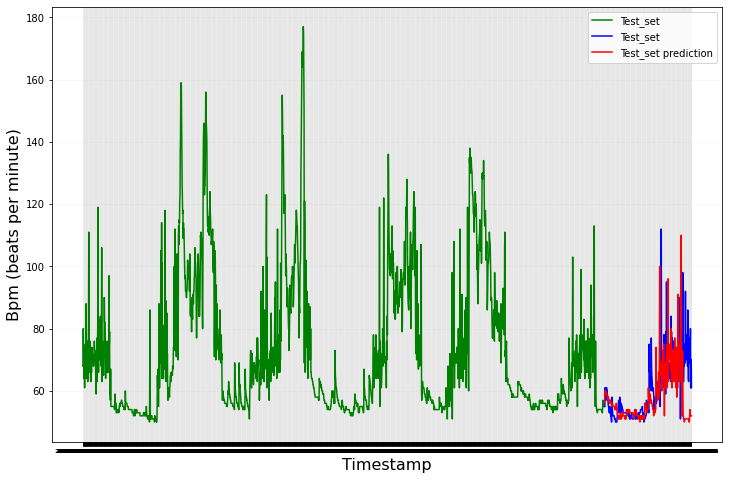

In [32]:
plot_full_series_vs_predicted_test(indexed_train, indexed_test, indexed_predicted_test)

# Real Time Algorithm

In [33]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

In [35]:
series = indexed_dataset
X = series['heartRate']
size = len(X) - 331
train, test = X[0:size], X[size:]
#history = [x for x in train]
#predictions = list()

best_score, best_cfg = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            history = []
            history = [x for x in train]
            predictions = list()
            try:
                for t in range(len(test)):
                    model = ARIMA(history, order=order)
                    model_fit = model.fit()
                    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
                    resid = model_fit.resid
                    diff = difference(history)
                    yhat = history[-1] + predict(ar_coef, diff) + predict(ma_coef, resid)
                    predictions.append(yhat)
                    obs = test[t]
                    history.append(obs)
                rmse = sqrt(mean_squared_error(test, predictions))                
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                print('ARIMA%s MSE=%.3f' % (order,rmse))
            except:
                continue
print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))


ARIMA(0, 0, 0) MSE=6.956
ARIMA(0, 0, 1) MSE=11.876
ARIMA(0, 0, 2) MSE=13.336
ARIMA(0, 1, 0) MSE=6.956
ARIMA(0, 1, 1) MSE=6.090
ARIMA(0, 1, 2) MSE=6.064
ARIMA(0, 2, 0) MSE=6.956
ARIMA(0, 2, 1) MSE=7.607
ARIMA(0, 2, 2) MSE=8.991
ARIMA(1, 0, 0) MSE=11.151
ARIMA(1, 0, 1) MSE=9.429
ARIMA(1, 0, 2) MSE=9.595
ARIMA(1, 1, 0) MSE=6.396
ARIMA(1, 1, 1) MSE=6.063
ARIMA(1, 1, 2) MSE=6.043
ARIMA(1, 2, 0) MSE=6.532
ARIMA(1, 2, 1) MSE=8.243
ARIMA(1, 2, 2) MSE=9.147
ARIMA(2, 0, 0) MSE=9.593
ARIMA(2, 0, 1) MSE=9.789
ARIMA(2, 0, 2) MSE=9.305
ARIMA(2, 1, 0) MSE=6.174
ARIMA(2, 1, 1) MSE=6.065
ARIMA(2, 1, 2) MSE=6.072
ARIMA(2, 2, 0) MSE=6.525
ARIMA(2, 2, 1) MSE=7.980
ARIMA(2, 2, 2) MSE=9.197
ARIMA(4, 0, 0) MSE=9.179
ARIMA(4, 0, 1) MSE=10.870
ARIMA(4, 0, 2) MSE=9.430
ARIMA(4, 1, 0) MSE=6.109
ARIMA(4, 1, 1) MSE=6.031
ARIMA(4, 1, 2) MSE=6.039
ARIMA(4, 2, 0) MSE=6.864
ARIMA(4, 2, 1) MSE=7.883
ARIMA(4, 2, 2) MSE=8.876
ARIMA(6, 0, 0) MSE=9.211
ARIMA(6, 0, 1) MSE=9.594
ARIMA(6, 0, 2) MSE=10.810
ARIMA(6, 1, 0) MSE=6

In [41]:
best_cfg

(4, 1, 1)

In [45]:
history = []
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=best_cfg)
    model_fit = model.fit()
    ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
    resid = model_fit.resid
    diff = difference(history)
    yhat = history[-1] + predict(ar_coef, diff) + predict(ma_coef, resid)
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions))                

# Saving a model

In [47]:
import pickle

In [48]:
# save the model to disk
filename = 'ARIMA(4,1,1).sav'
pickle.dump(model_fit, open(filename, 'wb'))

In [49]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
ar_coef, ma_coef = loaded_model.arparams, loaded_model.maparams
print(ar_coef)

[0.51530317 0.15562458 0.10474828 0.04261553]


In [ ]:
original_predicted_comparison(indexed_test, predictions)

In [ ]:
predicted_df2 = pd.DataFrame(test_dataset['date'], columns=['date'])
predicted_df2['heartRate'] = predictions

indexed_predicted_test_2 = predicted_df2.set_index(['date'])

In [ ]:
plot_full_series_vs_predicted_test(indexed_train, indexed_test, indexed_predicted_test_2)

In [ ]:
fig = plt.figure(figsize=(14,6))
# 121 = 1 row and 2 columns and goes to 1
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.hist(values, bins = np.unique(values)) 
ax1.set_title("HeartRate dataset histogram") 
ax1.set_xlabel('bpm', fontsize=16)
ax1.set_ylabel('# occurences', fontsize=16)

# Fit a normal distribution to the data:
mu, std = norm.fit(values)
# Plot the histogram.
ax2.hist(data, bins=np.unique(values), density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax2.plot(x, p, 'r', linewidth=2)
ax2.set_title("Fit results: mu = %.2f,  std = %.2f" % (mu, std))

plt.show()

## Save Model

In [ ]:
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
ARIMA.__getnewargs__ = __getnewargs__

In [ ]:
# save model
model_fit.save('model.pkl')
# load model
loaded = ARIMAResults.load('model.pkl')